In [1]:
import numpy as np
import torch
from diffusion import *
from torch.optim import Adam
import bgflow.distribution.sampling.mcmc as MCMC
import bgflow.distribution.energy.double_well as DoubleWell
import bgflow.distribution.normal as Normal
from diffusion.potential import LinearInterpolation 
from diffusion.utils import load_or_generate_and_then_save

torch.random.manual_seed(199)

device = 'cuda'

In [2]:
target = DoubleWell.DoubleWellEnergy(dim=1, b=-4., c=1.)
prior = Normal.NormalDistribution(dim=1)


net = torch.nn.Sequential(torch.nn.Linear(2, 64), torch.nn.SiLU(), torch.nn.Linear(64, 1)).to(device)

In [3]:
# the potential function
V = net #LinearInterpolation(prior, target, net)

In [4]:
def to_normalized_probabilities(energies):
    energies = torch.exp(-energies)
    energies = energies - energies.min(dim=0, keepdim=True)[0]
    energies = energies / energies.sum(dim=0, keepdim=True)
    return energies

In [29]:
naive_interpolation = lambda x, t :  (1-t) * target.energy(x) + (t) * prior.energy(x)

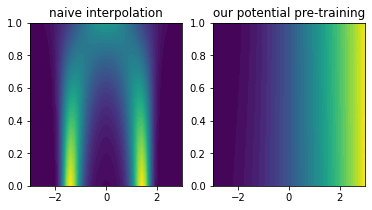

In [12]:
import matplotlib.pyplot as plt

ts = torch.linspace(0, 1, 50, dtype=torch.float32, device=device)
xs = torch.linspace(-3, 3, 50, dtype=torch.float32, device=device)

X, Y = torch.meshgrid(xs, ts, indexing='ij')

with torch.no_grad():
    pre_training_out = diff_model(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50,50)
pre_training_out = to_normalized_probabilities(pre_training_out)

naive_out = naive_interpolation(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50, 50)
naive_out = to_normalized_probabilities(naive_out)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.set_title('naive interpolation')
ax1.contourf(X.cpu(), Y.cpu(), naive_out.cpu(), levels=50)
ax2.set_title('our potential pre-training')
ax2.contourf(X.cpu(), Y.cpu(), pre_training_out.cpu(), levels=50)

plt.show()

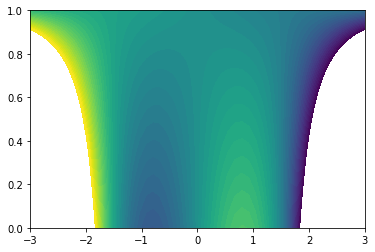

In [48]:
##### The force of the potential using naive interpolation between the double well and the harmonic well
X_copy = X.clone()
X_copy.requires_grad_(True)
energies = naive_interpolation(X_copy.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50, 50).sum()
naive_forces = -torch.autograd.grad(energies, X_copy)[0]

plt.contourf(X.cpu(), Y.cpu(), naive_forces.cpu(), levels=np.linspace(-10, 10, 50))

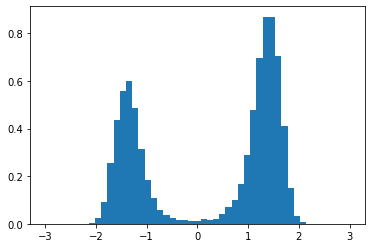

In [13]:
sampler = MCMC.GaussianMCMCSampler(energy=target, init_state=torch.tensor([0.]))


datafilepath = './data/double_well.npy'
data = torch.from_numpy(load_or_generate_and_then_save(datafilepath, lambda : sampler.sample(n_samples=50000)))

# plot histogram of the sampled data
counts, bins = np.histogram(data, bins=xs.cpu(), density=True)
# plt.plot(bins, torch.exp(-target.energy(torch.tensor(bins).unsqueeze_(1))))
plt.stairs(counts, bins, fill=True)
plt.show()


In [14]:
def cumulative_beta_linear(t):
    '''The integral of the noise schedule over the interval [0, t]. In this case a simple linear schedule'''
    return t

sde = SDE(TransitionKernel(cumulative_beta=cumulative_beta_linear))

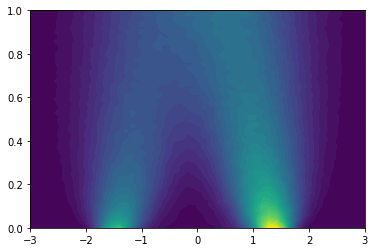

In [15]:
z = torch.zeros_like(X)
for i, t in enumerate(ts):
    t_s=torch.full_like(data, t)
    x_t = sde.forward_sample(x_0=data, t=t_s)
    z[:, i] = torch.histogram(x_t, bins=torch.cat([xs.cpu(), torch.tensor([6.])]))[0]


plt.contourf(X.cpu(), Y.cpu(), z.cpu(), levels=50)

In [16]:
batch_size = 128

diff_model = DiffusionModel(potential=V, device=device)

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
optimizer = Adam(diff_model.parameters(), lr=1e-3)


def MSE_loss(prediction, ground_truth):
    loss = ((prediction - ground_truth)**2).mean()
    return loss


In [17]:
from diffusion.train import train

train(diff_model, 
      sde=sde,
      loss_fn=MSE_loss, 
      optimizer=optimizer, 
      data_loader=train_loader, 
      n_iterations=50, 
      device=device)

Epoch 0/50 total loss: 303.3365478515625772766
Epoch 1/50 total loss: 286.07308959960943076176
Epoch 2/50 total loss: 277.12030029296875867076
Epoch 3/50 total loss: 265.62908935546875333864
Epoch 4/50 total loss: 232.20527648925786724854
Epoch 5/50 total loss: 209.37469482421875949224
Epoch 6/50 total loss: 210.79110717773438812134
Epoch 7/50 total loss: 204.68730163574226380626
Epoch 8/50 total loss: 206.39453125593210220337
Epoch 9/50 total loss: 208.34254455566406275397
Epoch 10/50 total loss: 206.4651184082031291727
Epoch 11/50 total loss: 204.0994110107422657593
Epoch 12/50 total loss: 200.3756866455078933966
Epoch 13/50 total loss: 202.1287536621093855896
Epoch 14/50 total loss: 201.2980804443359415454
Epoch 15/50 total loss: 197.9904174804687549796
Epoch 16/50 total loss: 199.6859436035156242664
Epoch 17/50 total loss: 198.2079925537109418026
Epoch 18/50 total loss: 200.6143646240234476255
Epoch 19/50 total loss: 200.5327606201172445017
Epoch 20/50 total loss: 196.1872406005859

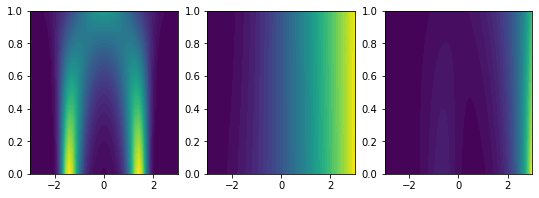

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

with torch.no_grad():
    post_training_out = diff_model(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50,50)
post_training_out = to_normalized_probabilities(post_training_out)

im1 = ax1.contourf(X.cpu(), Y.cpu(), naive_out.cpu(), levels=50)
im2 = ax2.contourf(X.cpu(), Y.cpu(), pre_training_out.cpu(), levels=50)
im3 = ax3.contourf(X.cpu(), Y.cpu(), post_training_out.cpu(), levels=50)

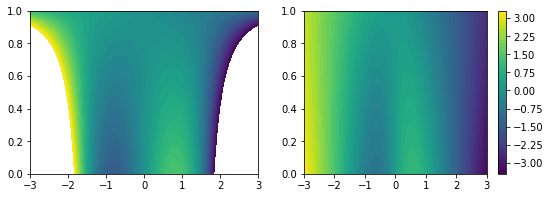

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

with torch.no_grad():
    post_training_out = diff_model(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50,50)

im1 = ax1.contourf(X.cpu(), Y.cpu(), naive_forces.cpu(), levels=np.linspace(-10, 10, 50))
im2 = ax2.contourf(X.cpu(), Y.cpu(), post_training_out.cpu(),  50)
plt.colorbar(im2)


In [50]:
from math import sqrt


def langevin(force: callable, x_0: torch.tensor, tau: torch.FloatType):
    '''Do langevin dynamics of the potential from x_0 at t=1 to x_t at t=0 with timestep tau.
    (actually, start at t=1e-5 for stability reasons)'''
    t = 1
    x_t = x_0
    sqrt_tau = sqrt(tau)
    while t > 1e-5:
        t_s = torch.full_like(x_t, t)
        with torch.no_grad():
            # x_t = x_t + tau * 0.5 * force.energy(x_t) + sqrt_tau * torch.rand_like(x_t)
            x_t = x_t + tau * 0.5 * force(torch.hstack([x_t, t_s])) + sqrt_tau * torch.randn_like(x_t)
        t -= tau
    return x_t


x_0 = torch.randn((10000, 1)).to(device)
x_t = langevin(net, x_0, 0.001)

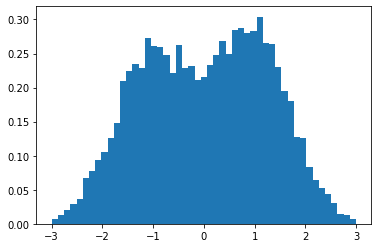

In [51]:
# plot histogram of the sampled data
counts, bins = np.histogram(x_t.cpu(), bins=xs.cpu(), density=True)
# plt.plot(bins, torch.exp(-target.energy(torch.tensor(bins).unsqueeze_(1))))
plt.stairs(counts, bins, fill=True)
plt.show()
